In [1]:
#TODO document jupyter
import torch
import pickle
import configparser
import sqlite3 as sl
import pandas as pd
import numpy as np

/home/gamal/anaconda3/envs/ds2f_m_i/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
configParser = configparser.RawConfigParser()   
configFilePath = r'configuration.txt'
configParser.read(configFilePath)
datasetPathDatabase =  configParser.get('COMMON', 'datasetPathDatabase') + '/dataset.db'


In [3]:
con = sl.connect(datasetPathDatabase)
data = con.execute("SELECT V.ID, V.VIDEO_PATH, V.AGE, V.ETHNICITY, V.GENDER, A.SPEAKER_EMB, A.LANG, F.FACE_PATH  FROM VIDEO V INNER JOIN AUDIO A ON V.ID = A.VIDEO_ID INNER JOIN FACE F ON V.ID = F.VIDEO_ID")
dataGotten = data.fetchall()

In [4]:
pd.set_option('display.max_columns', None)
df = pd.DataFrame(dataGotten,columns = ['ID','VIDEO_PATH','AGE','ETHNICITY','GENDER','SPEAKER_EMB','LANG','FACE_PATH'])


In [5]:
df['SPEAKER_EMB'] = df['SPEAKER_EMB'].apply(lambda x:pickle.loads(x))
print(df.head(1)['SPEAKER_EMB'])

0    [[[tensor(4.8478, device='cuda:0'), tensor(2.4...
Name: SPEAKER_EMB, dtype: object


In [6]:

print(df.head(1)['SPEAKER_EMB'][0].shape)

torch.Size([1, 1, 192])


In [7]:
import torch.nn.functional as F
# now we expand to size (7, 11) by appending a row of 0s at pos 0 and pos 6, 
# and a column of 0s at pos 10
#df['SPEAKER_EMB'] = df['SPEAKER_EMB'].apply(lambda x:print(x.shape))


In [8]:
#source = torch.rand((1,1,192))
# now we expand to size (7, 11) by appending a row of 0s at pos 0 and pos 6, 
# and a column of 0s at pos 10
# (4, 256, 768)
#print(source.shape)
#result = F.pad(input=source, pad=(1, 575), mode='constant', value=0)
#print(result.shape)
#result2 = result.unsqueeze(1).repeat(1,1,1,1)
#print(result2.shape)
#result3 = result2.squeeze()
#print(result3.shape)

In [9]:
import torch.nn.functional as F
# now we expand to size (7, 11) by appending a row of 0s at pos 0 and pos 6, 
# and a column of 0s at pos 10
with torch.no_grad():
    df['SPEAKER_EMB'] = df['SPEAKER_EMB'].apply(lambda x:F.pad(input=x, pad=(1, 575), mode='constant', value=0) )
    df['SPEAKER_EMB'] = df['SPEAKER_EMB'].apply(lambda x:x.unsqueeze(1).repeat(1,1,2,1) )
    df['SPEAKER_EMB'] = df['SPEAKER_EMB'].apply(lambda x:x.squeeze() )


In [10]:
import gc
torch.cuda.empty_cache()
gc.collect()

32

In [11]:
df.head(1)['SPEAKER_EMB'][0].shape

torch.Size([2, 768])

In [12]:
np_arr = df.head(1)['SPEAKER_EMB'][0].cpu().detach().numpy()
np_arr.shape

(2, 768)

In [13]:
df['SPEAKER_EMB'] = df['SPEAKER_EMB'].apply(lambda x:x.cpu().detach().numpy() )

In [14]:

df.head(1)['SPEAKER_EMB'][0].shape

(2, 768)

In [15]:

from PIL import Image
face_path = df.head(1)['FACE_PATH'][0]
im = Image.open(face_path)

In [16]:
np.array(im).shape

(32, 32, 4)

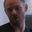

In [17]:
im.load() # required for png.split()

im2 = Image.new("RGB", im.size, (255, 255, 255))
im2.paste(im, mask=im.split()[3]) # 3 is the alpha channel
im2

In [18]:
im3 = np.array(im2)
np.array(im3).shape

(32, 32, 3)

In [19]:
im4 = np.rollaxis(im3,2)
im4.shape


(3, 32, 32)

In [20]:
#import torchvision.transforms as T
#from torchvision.io import read_image
#x = T.ToPILImage()(im4)
#x

In [21]:
def getImage(face_path):
    im = Image.open(face_path)
    im.load() # required for png.split()

    im2 = Image.new("RGB", im.size, (255, 255, 255))
    im2.paste(im, mask=im.split()[3]) # 3 is the alpha channel
    im3 = np.array(im2)
    im4 = np.rollaxis(im3,2)
    return im4

In [22]:
df['IMAGE'] = df['FACE_PATH'].apply(lambda x:getImage(x) )

In [23]:
df.head(1)['IMAGE'][0].shape

(3, 32, 32)

In [24]:
df.head(1)['SPEAKER_EMB'][0]

array([[0.       , 4.8477864, 2.436525 , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 4.8477864, 2.436525 , ..., 0.       , 0.       ,
        0.       ]], dtype=float32)

In [25]:
with torch.no_grad():
    input_tensor = torch.tensor(df['SPEAKER_EMB']).cuda()


/tmp/ipykernel_109037/3490873246.py:2: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /home/conda/feedstock_root/build_artifacts/pytorch-recipe_1673752754831/work/torch/csrc/utils/tensor_new.cpp:230.)
  input_tensor = torch.tensor(df['SPEAKER_EMB']).cuda()


In [26]:
torch.cuda.empty_cache()

In [27]:
input_tensor.shape

torch.Size([1008, 2, 768])

In [28]:
input_tensor

tensor([[[ 0.0000,  4.8478,  2.4365,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  4.8478,  2.4365,  ...,  0.0000,  0.0000,  0.0000]],

        [[ 0.0000,  4.8478,  2.4365,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  4.8478,  2.4365,  ...,  0.0000,  0.0000,  0.0000]],

        [[ 0.0000,  4.8478,  2.4365,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  4.8478,  2.4365,  ...,  0.0000,  0.0000,  0.0000]],

        ...,

        [[ 0.0000,  0.0887, -5.2107,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0887, -5.2107,  ...,  0.0000,  0.0000,  0.0000]],

        [[ 0.0000,  0.0887, -5.2107,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0887, -5.2107,  ...,  0.0000,  0.0000,  0.0000]],

        [[ 0.0000,  0.0887, -5.2107,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0887, -5.2107,  ...,  0.0000,  0.0000,  0.0000]]],
       device='cuda:0')

In [29]:
output_tensor = torch.tensor(df['IMAGE']).cuda()


In [30]:
output_tensor.shape

torch.Size([1008, 3, 32, 32])

In [31]:
output_tensor.shape

torch.Size([1008, 3, 32, 32])

In [32]:
import torch
from imagen_pytorch import Unet, Imagen
from PIL import Image
import numpy as np
import torchvision
import torchvision.transforms as T
from torchvision.io import read_image


In [33]:
unet1 = Unet(
    dim = 16,
    cond_dim = 256,
    dim_mults = (1, 2, 4, 8),
    num_resnet_blocks = 3,
    layer_attns = (False, True, True, True),
    layer_cross_attns = (False, True, True, True)
)

#unet2 = Unet(
#    dim = 32,
#    cond_dim = 512,
#    dim_mults = (1, 2, 4, 8),
#    num_resnet_blocks = (2, 4, 8, 8),
#    layer_attns = (False, False, False, True),
#    layer_cross_attns = (False, False, False, True)
#)

# imagen, which contains the unets above (base unet and super resoluting ones)

imagen = Imagen(
    unets = (unet1),#, unet2),
    image_sizes = (32),
    timesteps = 100,
    cond_drop_prob = 0.1
).cuda()


The base dimension of your u-net should ideally be no smaller than 128, as recommended by a professional DDPM trainer https://nonint.com/2022/05/04/friends-dont-let-friends-train-small-diffusion-models/


In [34]:
print(input_tensor.shape)
print(output_tensor.shape)

torch.Size([1008, 2, 768])
torch.Size([1008, 3, 32, 32])


In [35]:
#text_embeds = torch.randn(4, 128, 768).cuda()
#print(text_embeds.shape)

#images = torch.randn(4, 3, 256, 256).cuda()
#print(images.shape)

In [36]:


with torch.no_grad():
    torch.cuda.empty_cache()



In [37]:
torch.cuda.empty_cache()
input_tensor.shape

torch.Size([1008, 2, 768])

In [38]:
#for i in (1):#, 2):
#    loss = imagen(images, text_embeds = text_embeds, unet_number = 1)
#    loss.backward()
loss = imagen(output_tensor, text_embeds = input_tensor, unet_number = 1,max_batch_size = 1)
loss.backward()

TypeError: forward() got an unexpected keyword argument 'max_batch_size'

: 

In [ ]:
images = imagen.sample(text_embeds=input_tensor, cond_scale = 3.)

sampling loop time step: 100%|██████████| 100/100 [00:15<00:00,  6.33it/s]
1it [00:15, 15.98s/it]


In [ ]:
im_numpy = images.cpu().numpy()
im1 = np.transpose(im_numpy[0], (1,2,0))
im1f  = (im1 * 255 / np.max(im1)).astype('uint8')
x = T.ToPILImage()(im1f)
x.show()


(eog:69516): Gtk-WARNING **: 11:03:52.638: Could not load a pixbuf from icon theme.
This may indicate that pixbuf loaders or the mime database could not be found.
